# Monte Carlo Strategy Backtesting

In [1]:
%pylab inline
import pandas as pd
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


### Remove trailing zeros


When creating moving averages we are losing a few periods at the head of the series. We want to fill this up with the first set value that we encounter in the series.

In [2]:
def remove_trailing_zeros(values):
    """Replace every 0 with 'nan' and return a copy."""
    start = 0
    for i in range(0, len(values)):
        start = i
        if values[i] != 0:
            break
    for i in range(0, start):
        values[i] = values[start]   
    return values

### Init

Initializing the Monte Carlo simulation with variables:

1. $u$ = the log mean
2. $Var$ = the log variance
3. $\text{Drift} = u - \dfrac{1}{2} \cdot \text{Var}$
4. $\text{Stdev} = \sqrt{\text{Var}}$ (standard deviation)

The following values have been calculated for Bitcoin for a time period of the previous three years.

* $u = 0.003717834$.
* $\text{Var} = 0.00172476$.

In [3]:
u = 0.003717834
var = 0.00172476
drift = u - (0.5 * var)
stdev = math.sqrt(var)

In [4]:
def generate_monte_carlo_chart(drift, stdev, t_intervals, start):
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, 1)))
    price_list = np.zeros_like(daily_returns)
    price_list[0] = start
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    return price_list

### Run the simulation

In [5]:
chart = generate_monte_carlo_chart(drift, stdev, 365, 12000)

## Indicators

### Simple Moving Average

In [6]:
def sma(values, n):
    sma = np.zeros_like(values)
    for i in range(n, len(values)):
        avg = np.sum(values[i-n:i])/n
        sma[i] = avg
    return remove_trailing_zeros(sma)

### MACD

In [7]:
def macd(values, ma1, ma2, sl):
    macd = ma2 - ma1
    sma = np.ones_like(values) * macd[sl]
    for i in range(sl-1, len(macd)):
        avg = np.sum(macd[i-sl:i])/sl
        sma[i] = avg
    return [macd, sma]        

### Calculating the indicators

In [8]:
sma7 = sma(chart, 7)
sma14 = sma(chart, 14)
sma26 = sma(chart, 26)
sma12 = sma(chart, 12)
macd, sl = macd(chart, sma(chart, 14), sma(chart, 7), 9)

## Plotting the Monte Carlo series and Indicators

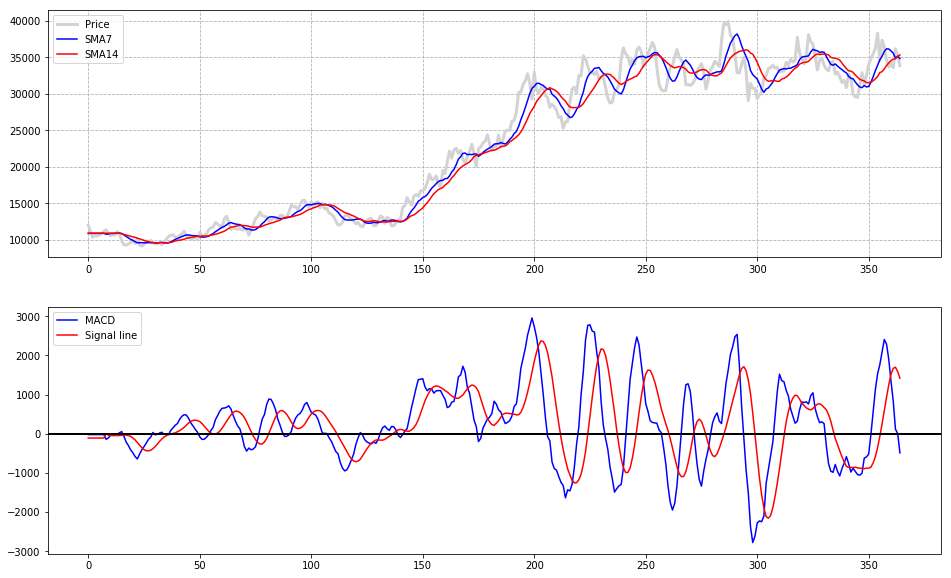

In [9]:
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot(chart, c='lightgrey', lw=3);
plt.plot(sma7, c='b')
plt.plot(sma14, c='r')
legend(['Price', 'SMA7', 'SMA14']);
grid(linestyle='--')

plt.subplot(2,1,2)
plt.plot(macd, c='b')
plt.plot(sl, c='r')
#plt.fill_between(range(0, len(macd_area)), 0, np.array(macd_area), facecolor='lightgray')
plt.axhline(0,c='black',lw=2, linestyle='solid')
legend(['MACD', 'Signal line']);

## Strategies

In [10]:
equity_start = 1000

### HODL

Easy thing to do...

In [11]:
hodl_coefficient = chart[len(chart)-1]/chart[0]
print('Hodling yields: %f, equity %f (Started with: %i)' % (hodl_coefficient.item(0), hodl_coefficient.item(0) * equity_start, equity_start))

Hodling yields: 2.822040, equity 2822.039510 (Started with: 1000)


### MACD Crossover Strategy

This is a very simple strategy where we go long when the MACD crosses into the positive zone and go short when the MACD is in the negative zone.

* Add EMA!
* Fix crossover!

#### Generating signals

In [12]:
start = 0
for i in range(0,len(sl)):
    start = i
    if not np.isnan(sl[i]):
        break

In [13]:
macd_prev = sl[i]
signals = []
for i in range(start, len(chart)):
    if macd_prev < 0 and sl[i] > 0:
        signals.append(['buy', i])
    elif macd_prev > 0 and sl[i] < 0:
        signals.append(['sell', i])
    macd_prev = sl[i]

if signals[len(signals)-1][0] == 'buy':
    signals.append(['sell', len(chart)-1])

In [14]:
len(signals)

20

#### Plotting the signals

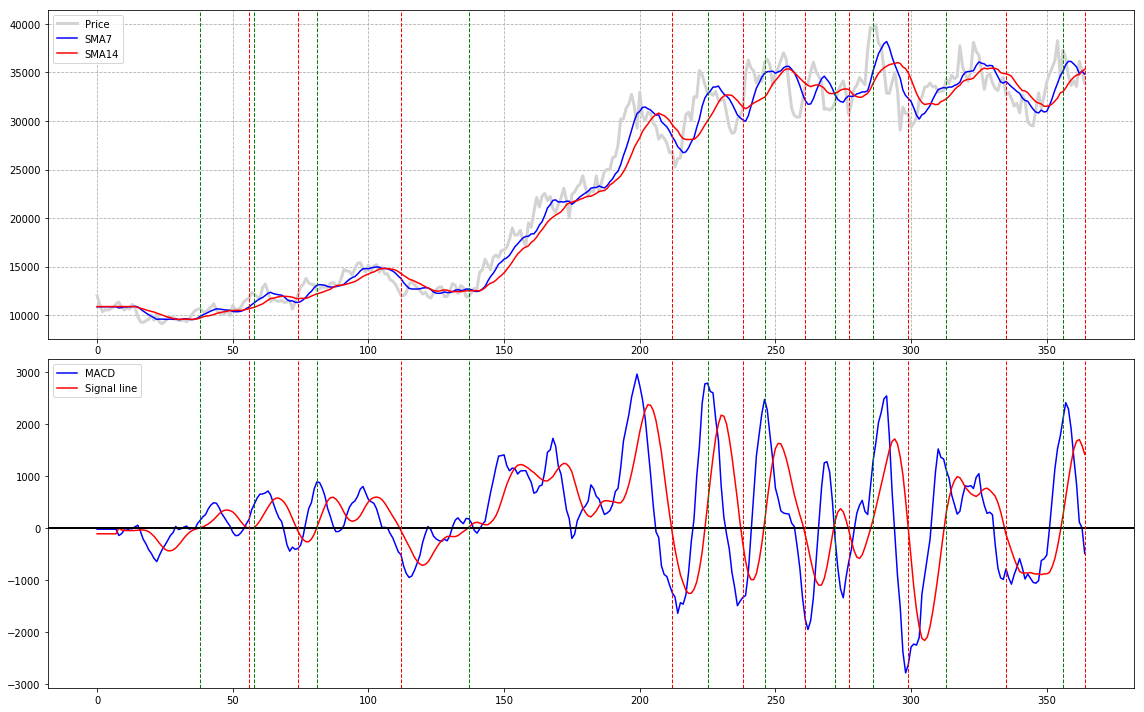

In [15]:
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot(chart, c='lightgrey', lw=3);
plt.plot(sma7, c='b')
plt.plot(sma14, c='r')
legend(['Price', 'SMA7', 'SMA14']);
grid(linestyle='--')
for s in signals:
    color = 'red'
    if s[0] == 'buy':
        color = 'green'
    plt.axvline(s[1],c=color,lw=1, linestyle='--')
    
plt.subplot(2,1,2)
plt.plot(macd, c='b')
plt.plot(sl, c='r')
#plt.fill_between(range(0, len(macd_area)), 0, macd_area, facecolor='lightgray')
plt.axhline(0,c='black',lw=2, linestyle='solid')
plt.tight_layout(h_pad=0)
legend(['MACD', 'Signal line']);
for s in signals:
    color = 'red'
    if s[0] == 'buy':
        color = 'green'
    plt.axvline(s[1],c=color,lw=1, linestyle='--')

The strategy is overtrading a lot which is the main cause for it's poor results.

#### Stats

In [16]:
trades = []
bought_at = 0
no_of_trades = 0
losing_streak = 0
longest_losing_streak = 0
equity = equity_start

for i in range(0,len(signals)-1):
    if signals[i][0] == 'buy':
        bought_at = i
    else:
        coefficient = chart[i]/chart[bought_at]
        equity *= coefficient
        
        if coefficient < 1:
            losing_streak += 1
            if losing_streak > longest_losing_streak:
                longest_losing_streak = losing_streak
        else:
            losing_streak = 0
        trades.append([signals[i][1], coefficient])
        no_of_trades += 1

In [17]:
index, coeff = zip(*trades)
equity

array([ 919.715171])

In [18]:
print('MACD Signal Trading yields: %i trades, equity %f (Started with %i)' % (len(trades), equity, equity_start))
print('Hodling yields: %f, equity %f (Started with: %i)' % (hodl_coefficient.item(0), hodl_coefficient.item(0) * equity_start, equity_start))

MACD Signal Trading yields: 9 trades, equity 919.715171 (Started with 1000)
Hodling yields: 2.822040, equity 2822.039510 (Started with: 1000)


In [19]:
print('Stdev: %f' % math.sqrt(np.var(coeff)))

Stdev: 0.043543


In [20]:
print('Longest losing streak: %i' % longest_losing_streak)

Longest losing streak: 2


## To do

Add:

* Equity curve plot
* Exponential Moving Average
* Relative Strength Index
* Bollinger Bands
* Fix that stupid HODLing message
* Moving Averages Crossover Strategy for any $n$-periods